In [1]:
import os
import io

import boto3
import pandas as pd
import numpy as np
from datetime import datetime

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

# Code to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
role = get_execution_role()
bucket='awsml-730qej'

In [3]:
data_key = 'hepatitis.xlsx'
data_location = f's3://{bucket}/{data_key}'

In [4]:
data = pd.read_excel(data_location)
data.head()

,ID,target,age,gender,steroid,antivirals,fatigue,malaise,anorexia,liverBig,...,spleen,spiders,ascites,varices,bili,alk,sgot,albu,protime,histology
0,1,1,30,2,1,2,2,2,2,1,...,2,2,2,2,1.0,85,18,4.0,61,1
1,2,1,50,1,1,2,1,2,2,1,...,2,2,2,2,0.9,135,42,3.5,61,1
2,3,1,78,1,2,2,1,2,2,2,...,2,2,2,2,0.7,96,32,4.0,61,1
3,4,1,31,1,1,1,2,2,2,2,...,2,2,2,2,0.7,46,52,4.0,80,1
4,5,1,34,1,2,2,2,2,2,2,...,2,2,2,2,1.0,46,200,4.0,61,1


In [5]:
print('Dataset has ' + str(data.shape[0]) + ' rows, and ' + str(data.shape[1]) + ' columns')

Dataset has 155 rows, and 21 columns


In [6]:
data.target.value_counts()

1    123
0     32
Name: target, dtype: int64

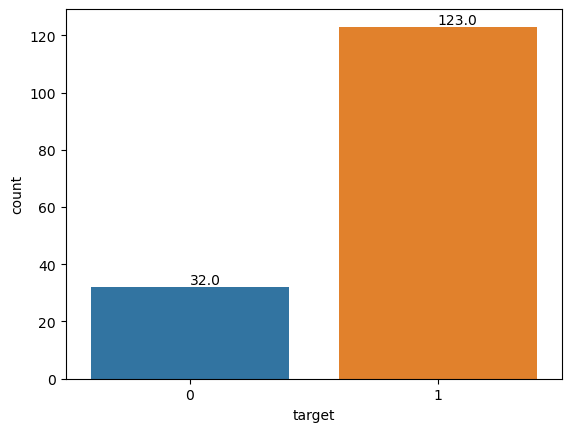

In [7]:
y_count=sns.countplot(x='target',data=data)        
# Shows the count of observations in each categorical bin using bars

for p in y_count.patches:
    height = p.get_height()
    # Add text to the axes
    y_count.text(p.get_x()+p.get_width()/2, height + 1, height)
# The y_count.text method takes an x position, a y position and a string

In [8]:
data.drop(["ID"], axis = 1, inplace=True)

In [9]:
num_cols = ["age", "bili", "alk", "sgot", "protime"]
cat_cols = ['gender', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liverBig', 
            'liverFirm', 'spleen', 'spiders', 'ascites', 'varices', 'histology']

In [10]:
data[cat_cols] = data[cat_cols].astype('category')

In [11]:
data.dtypes

target           int64
age              int64
gender        category
steroid       category
antivirals    category
fatigue       category
malaise       category
anorexia      category
liverBig      category
liverFirm     category
spleen        category
spiders       category
ascites       category
varices       category
bili           float64
alk              int64
sgot             int64
albu           float64
protime          int64
histology     category
dtype: object

In [12]:
data.columns

Index(['target', 'age', 'gender', 'steroid', 'antivirals', 'fatigue',
       'malaise', 'anorexia', 'liverBig', 'liverFirm', 'spleen', 'spiders',
       'ascites', 'varices', 'bili', 'alk', 'sgot', 'albu', 'protime',
       'histology'],
      dtype='object')

In [13]:
# OneHotEncoding
data = pd.get_dummies(data, columns=['gender', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liverBig', 
            'liverFirm', 'spleen', 'spiders', 'ascites', 'varices', 'histology'],drop_first=True)

In [14]:
display(data.head())
display(data.shape)

,target,age,bili,alk,sgot,albu,protime,gender_2,steroid_2,antivirals_2,fatigue_2,malaise_2,anorexia_2,liverBig_2,liverFirm_2,spleen_2,spiders_2,ascites_2,varices_2,histology_2
0,1,30,1.0,85,18,4.0,61,1,0,1,1,1,1,0,1,1,1,1,1,0
1,1,50,0.9,135,42,3.5,61,0,0,1,0,1,1,0,1,1,1,1,1,0
2,1,78,0.7,96,32,4.0,61,0,1,1,0,1,1,1,1,1,1,1,1,0
3,1,31,0.7,46,52,4.0,80,0,0,0,1,1,1,1,1,1,1,1,1,0
4,1,34,1.0,46,200,4.0,61,0,1,1,1,1,1,1,1,1,1,1,1,0


(155, 20)

In [15]:
np.random.seed(0)
rand_split = np.random.rand(len(data))

train_list = rand_split < 0.8
test_list = rand_split >= 0.8

 # This dataset will be used to train the model.
data_train = data[train_list]

# This dataset will be used to validate the model.
#data_val = data[val_list]

# This dataset will be used to test the model.
data_test = data[test_list]

# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
X_train = data_train.drop(columns='target').values
y_train = data_train['target'].values


X_test = data_test.drop(columns='target').values
y_test = data_test['target'].values

In [16]:
data_train

,target,age,bili,alk,sgot,albu,protime,gender_2,steroid_2,antivirals_2,fatigue_2,malaise_2,anorexia_2,liverBig_2,liverFirm_2,spleen_2,spiders_2,ascites_2,varices_2,histology_2
0,1,30,1.0,85,18,4.0,61,1,0,1,1,1,1,0,1,1,1,1,1,0
1,1,50,0.9,135,42,3.5,61,0,0,1,0,1,1,0,1,1,1,1,1,0
2,1,78,0.7,96,32,4.0,61,0,1,1,0,1,1,1,1,1,1,1,1,0
3,1,31,0.7,46,52,4.0,80,0,0,0,1,1,1,1,1,1,1,1,1,0
4,1,34,1.0,46,200,4.0,61,0,1,1,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,1,20,0.9,89,152,4.0,61,0,0,1,1,1,1,1,1,1,1,1,1,1
150,0,46,7.6,104,242,3.3,50,0,1,1,0,0,0,1,1,1,0,0,0,1
152,1,61,0.8,75,20,4.1,61,0,0,1,0,0,1,0,0,1,0,1,1,1
153,1,53,1.5,81,19,4.1,48,1,0,1,0,1,1,1,1,0,0,1,0,1


In [17]:
data_test

,target,age,bili,alk,sgot,albu,protime,gender_2,steroid_2,antivirals_2,fatigue_2,malaise_2,anorexia_2,liverBig_2,liverFirm_2,spleen_2,spiders_2,ascites_2,varices_2,histology_2
7,1,23,1.0,104,54,1.4,61,0,1,1,1,1,1,1,1,1,1,1,1,0
8,1,39,0.7,104,48,4.4,61,0,1,1,0,1,1,1,0,1,1,1,1,0
13,1,30,2.2,57,144,4.9,78,0,1,1,0,1,1,1,0,1,1,1,1,0
17,1,40,0.6,62,166,4.0,63,0,0,1,0,1,1,1,0,1,1,1,1,0
19,1,38,0.7,70,28,4.2,62,0,0,0,1,1,1,0,0,1,1,1,1,0
20,1,22,0.9,48,20,4.2,64,1,1,0,0,1,1,1,1,1,1,1,1,0
27,1,58,1.4,175,55,2.7,36,1,1,1,0,1,1,1,0,1,0,1,1,0
38,1,42,1.0,85,14,4.0,100,0,0,1,1,1,1,1,1,1,1,1,1,0
52,1,44,0.6,110,145,4.4,70,0,1,1,1,1,1,1,1,1,1,1,1,0
66,1,56,0.7,62,33,3.0,61,0,0,1,1,1,1,1,1,1,1,1,1,0


In [18]:
X_train.shape

(127, 19)

In [19]:
X_test.shape

(28, 19)

In [21]:
train_file = 'training_data'
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_train.astype('float32'), y_train.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(f'{train_file}').upload_fileobj(f)
training_recordIO_protobuf_location = f's3://{bucket}/{train_file}'
print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

The Pipe mode recordIO protobuf training data: s3://awsml-730qej/training_data


In [22]:
validation_file = 'validation_data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_test.astype('float32'), y_test.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(f'{validation_file}').upload_fileobj(f)
validate_recordIO_protobuf_location = f's3://{bucket}/{validation_file}'
print('The Pipe mode recordIO protobuf validation data: {}'.format(validate_recordIO_protobuf_location))

The Pipe mode recordIO protobuf validation data: s3://awsml-730qej/validation_data


In [24]:
from sagemaker import image_uris, model_uris, script_uris

In [25]:
container = image_uris.retrieve('knn', boto3.Session().region_name, 'latest')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [26]:
# Create a training job name
job_name = 'hepatitis-job3-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

# Here is where the model-artifact will be stored
output_location = f's3://{bucket}/model-artifact/'

Here is the job name hepatitis-job3-20230428065834


In [27]:
print('The feature_dim hyperparameter needs to be set to {}.'.format(X_train.shape[1]))

The feature_dim hyperparameter needs to be set to 19.


In [28]:
X_train.shape

(127, 19)

In [29]:
hyperparams = {"feature_dim": 19, "k": 10, "sample_size": 20, "predictor_type": "classifier"}

In [30]:
sess = sagemaker.Session()

# Setup the KNNLeaner algorithm from the ECR container
knn = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess,
                                    input_mode='Pipe')

In [32]:
# Setup the hyperparameters
knn.set_hyperparameters(feature_dim=19,
                        k=3,
                        sample_size=20,
                        predictor_type='classifier')

In [33]:
# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {'train': training_recordIO_protobuf_location,
                 'validation': validate_recordIO_protobuf_location}

In [34]:
knn.fit(data_channels, job_name=job_name)

INFO:sagemaker:Creating training-job with name: hepatitis-job3-20230428065834


2023-04-28 07:08:28 Starting - Starting the training job...
2023-04-28 07:09:05 Starting - Preparing the instances for training.........
2023-04-28 07:10:37 Downloading - Downloading input data
2023-04-28 07:10:37 Training - Downloading the training image........................
2023-04-28 07:14:29 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/28/2023 07:14:49 INFO 140625675921216] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_profiler': 'false'}
[04/28/2023 07:14:49 INFO 140625675921216] M

In [ ]:
print('Here is the location of the trained KNN model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

In [37]:
hepatitis_predictor = knn.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: knn-2023-04-28-08-18-03-769
INFO:sagemaker:Creating endpoint-config with name knn-2023-04-28-08-18-03-769
INFO:sagemaker:Creating endpoint with name knn-2023-04-28-08-18-03-769


------------!

In [39]:
hepatitis_predictor.endpoint_name

'knn-2023-04-28-08-18-03-769'

In [40]:
hepatitis_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [41]:
hepatitis_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

predictions = []
results = hepatitis_predictor.predict(X_test)
predictions += [r['predicted_label'] for r in results['predictions']]
predictions = np.array(predictions)

In [42]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

y_test = data_test['target']
y_pred = predictions
scores = precision_recall_fscore_support(y_test, y_pred, average='macro', labels=np.unique(y_pred))
acc = accuracy_score(y_test, y_pred)
print('Accuracy is: {}'.format(acc))
print('Precision is: {}'.format(scores[0]))
print('Recall is: {}'.format(scores[1]))
print('F1 score is: {}'.format(scores[2]))

Accuracy is: 0.7142857142857143
Precision is: 0.37037037037037035
Recall is: 0.47619047619047616
F1 score is: 0.4166666666666667


In [43]:
import matplotlib.pyplot as plt

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

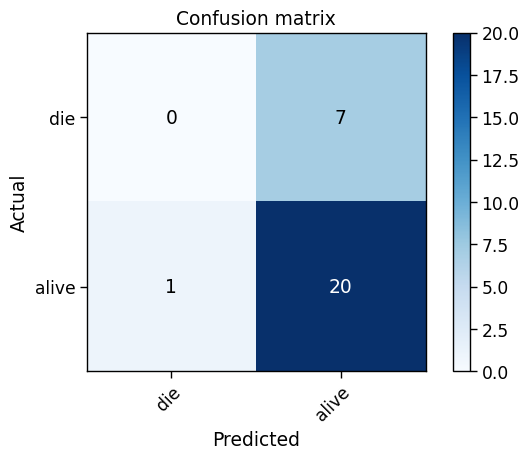

In [45]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = y_test
y_pred = predictions

class_names = np.array(['die', 'alive'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)
plt.show()